In [1]:
import numpy as np
from scipy import optimize
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
# define constants and arrays
kB       = 1.38064852e-23  # Boltzmann constant J/K
NA       = 6.0221409e+23   # Avogadro's number
T        = np.array([np.float64(200.0+i*0.01) for i in range(0, 7000, 1)])

In [3]:
# Experimental data from Murray's group

# load Murray 2010 data Run1
data_dir = "/Users/danielschlesinger/Desktop/IceNucExp/fromJonas/Nucleation_rate_data/"
data = np.loadtxt(data_dir + 'Murray_dataset/Ben1.txt')
T_Ben1 = data[:,0]
J_Ben1 = data[:,1]*10**6
J_up_Ben1 =data[:,2]*10**6
J_down_Ben1 = data[:,3]*10**6

# load Murray 2010 data Run2
data = np.loadtxt(data_dir + 'Murray_dataset/Ben2.txt')
T_Ben2 = data[:,0]
J_Ben2 = data[:,1]*10**6
J_up_Ben2 =data[:,2]*10**6
J_down_Ben2 = data[:,3]*10**6

# load Murray 2021 (latest publication)
Run1 = np.loadtxt(data_dir + 'Murray_dataset/Murray_Run1.txt')
Run2 = np.loadtxt(data_dir + 'Murray_dataset/Murray_Run2.txt')
Run3 = np.loadtxt(data_dir + 'Murray_dataset/Murray_Run3.txt')

# Run 1
T_Murray_R1 = Run1[:,0] + 273.
T_R1_err = Run1[:,1]
J_Murray_R1 = Run1[:,2]*10**6
J_R1_up = Run1[:,3]*10**6
J_R1_down = Run1[:,4]*10**6

# Run 2
T_Murray_R2 = Run2[:,0] + 273.
T_R2_err = Run2[:,1]
J_Murray_R2 = Run2[:,2]*10**6
J_R2_up = Run2[:,3]*10**6
J_R2_down = Run2[:,4]*10**6

# Run 3
T_Murray_R3 = Run3[:,0] + 273.
T_R3_err = Run3[:,1]
J_Murray_R3 = Run3[:,2]*10**6
J_R3_up = Run3[:,3]*10**6
J_R3_down = Run3[:,4]*10**6

In [4]:
# Experimental data from Jonas' group

# Mar 12 2020
file_dir = "/Users/danielschlesinger/Desktop/IceNucExp/fromJonas/Nucleation_rate_data/"
data = np.loadtxt(file_dir + 'MC_error/Mar_12_interpolatedpos.txt')
T1_MC = data[:,4]
J1_MC = data[:,-3]
T1_MC_low = data[:,5]
T1_MC_high = data[:,6]
J1_MC_low = data[:,-2]
J1_MC_high = data[:,-1]

# Nov 3 2020
data = np.loadtxt(file_dir + 'MC_error/Nov_3_interpolatedpos.txt')
T2_MC = data[:,4]
J2_MC = data[:,-3]
T2_MC_low = data[:,5]
T2_MC_high = data[:,6]
J2_MC_low = data[:,-2]
J2_MC_high = data[:,-1]

# Dec 7 2020
data = np.loadtxt(file_dir + 'MC_error/Dec_7_interpolatedpos.txt')
T3_MC = data[:,4]
J3_MC = data[:,-3]
T3_MC_low = data[:,5]
T3_MC_high = data[:,6]
J3_MC_low = data[:,-2]
J3_MC_high = data[:,-1]

# Laksmono JPCL (2014)
T_laksmono = np.array([230.42,228.19,227.08,231.79,229.16])
J_laksmono = np.array([2.11E+11,3.22E+12,3.58E+12,2.69E+11,8.45E+11])*1e6 # /m^3/s
T_laksmono_low = np.array([1.00, 1.00, 1.00, 1.00, 1.00])
T_laksmono_high = np.array([2.00, 2.00, 2.00, 2.00, 2.00])
J_laksmono_low = np.array([1.38E+11, 7.90E+11, 2.79E+12, 3.90E+10, 3.71E+11])*1E+6
J_laksmono_high = np.array([3.12E+12, 4.60E+13, 5.76E+13, 3.81E+12, 1.22E+13])*1E+6

In [5]:
# Ice nucleation rate following Laksmono 2015

def rho(T):
    """ 
    mass density
    """
    #dens = 1000.0*(-1.3103e-9*pow(T,3) + 3.8109e-7*pow(T, 2) - 9.259e-5*T+ 0.94040)   # cubic ice, [kg m^-3]
    dens = 933.942 + 66.7829 / (1.0 + np.exp( - 0.10662 * (T - 233.0573)))               # hexagonal ice, [kg m^-3]
    return dens

def rho_Ih(T):
    dens_ice = (-1.3103e-9*T*T*T + 3.8109e-7*T*T - 9.259e-5*T + 0.94040)*1000.0   # kg m^-3
    return dens_ice
    
def vmol(T):
    """
    molecular volume
    """
    vmolec = 0.01801528 / (NA * rho(T))         # [m^3]
    return vmolec

def vmol_Ih(T):
    """
    molecular volume ice Ih
    """
    vmolec = 0.01801528 / (NA * rho_Ih(T))     # [m^3]
    return vmolec


def sigma(T):
    """
    liquid-ice surface tension
    """
    #s = 0.0208 * np.power(T / 235.8, 0.3)                        # liq-ice surface tension, Laksmono 2015, [J m^-2] 
    s = 1.198100169422e-11*T**6 - 1.644226732545e-8*T**5 + 9.387801708449e-6*T**4 - 2.854359440278e-3*T**3 + 4.874466166395e-1*T**2 - 4.433154987346e+1*T + 1.677613823216e+3 # VFT, J/m^2
    return s

def sig(T):
    """
    vapour-liquid surface tension
    """
    s = (111.63 - 0.13167*T)/1000       # J/m^2 #  J/m^2
    return s

def D(T):
    """
    diffusivity
    """
    diff = 4.14e-8 * np.exp(-347.0 / (T - 177.0))                       # VFT, 0.1 MPa
    #diff = 1.67e-14 * np.exp(0.05698332*T*T - 27.28998*T + 3271.878)  # diffusivity water, [m^2/s] ERRONEOUS
    return diff

def Pvap(T):
    """
    saturation vapour pressure liq water
    """
    P = np.exp(54.842763 - 6763.22/T - 4.210*np.log(T) + 0.000367*T + np.tanh(0.0415*(T - 218.8))*(53.878 - 1331.22/T - 9.44523*np.log(T) + 0.014025*T))    # Murphy & Koop 2005
    return P

def Pvap_Ih(T):
    """
    saturation vapour pressure over ice Ih
    """
    P = np.exp(9.550426 - 5723.265 / T + 3.53068* np.log(T) - 0.00728332*T)    # Murphy & Koop 2005
    return P

def dmu(T, R=10.0e-6):
    """
    difference in chemical potential between liquid and solid phase (cubic ice) 
    """
    Ic_fac   = np.exp(155.0 / (kB * T * NA))                     # conversion Pvap_ice Ih -> Ic, Laksmono 
    deltamu = -kB * T * np.log(Pvap(T) / (Pvap_Ih(T) * Ic_fac)) +(Pvap(T) + 2*sig(T)/R - (Pvap_Ih(T) * Ic_fac))*vmol_Ih(T) - (2*sig(T)/R)*vmol(T)   # assuming microdroplets, below 1mu need Laplace correction
    return deltamu
    
def dF(T):
    """
    thermodynamic free energy barrier for nucleation
    """
    DeltaF = 16.0 * np.pi * np.power(vmol_Ih(T), 2) * np.power(sigma(T), 3) / (np.power(dmu(T), 2) * 3.0)
    return DeltaF
        
def df(T):
    """
    kinetic free energy barrier activation liquid -> solid
    """
    deltaf = -kB*np.gradient(np.log(D(T)), np.gradient(1.0/T))
    return deltaf
    
def J0(T):
    """
    nucleation rate prefactor (incl Zeldovich)
    """
    pref = 16.0*np.power(3.0*np.pi/4.0, 1.0/3.0)*np.sqrt(sigma(T) / (kB * T)) * D(T) / np.power(vmol_Ih(T), 4.0/3.0)
    return pref
    
def Jnuc_LM(T):
    """
    nucleation rate as used in Laksmono 2015
    """
    Jnuc = J0(T) * np.exp(-dF(T) / (kB * T))
    return Jnuc


In [6]:
# Ice nucleation rate parameterizations 

def Jnuc_KM(T):
    """
    nucleation rate Koop & Murphy 2016
    fit using Laksmono 2015 data
    """
    t = T - 273.15
    x = -3020.684 - 425.921*t - 25.9779*np.power(t, 2) - 0.868451*np.power(t, 3) - 1.66203e-2*np.power(t, 4) - 1.71736e-4*np.power(t, 5) -7.46953e-7*np.power(t, 6)
    Jnuc = 1e+6 * np.power(10, x)
    return Jnuc


In [7]:
# prepare experimental data for fit
def symlog(x):
    """
    definition of log scale with 
    """
    input = np.array(x)
    output = np.zeros_like(x)
    output[np.where(input > 1.)] = np.log10(input[np.where(input > 1.)])
    output[np.where(input < -1.)] = -np.log10(-input[np.where(input < -1.)])
    return output

#T_data = np.hstack([T1_MC[np.where((J1_MC > 1e16) & (T1_MC < 235))], T2_MC[np.where((J2_MC > 1e16) & (T2_MC < 235))], T3_MC[np.where(J3_MC > 1e16)], T_Murray_R1, T_Murray_R2, T_Murray_R3, T_laksmono])
#J_data = np.hstack([J1_MC[np.where((J1_MC > 1e16) & (T1_MC < 235))], J2_MC[np.where((J2_MC > 1e16) & (T2_MC < 235))], J3_MC[np.where(J3_MC > 1e16)], J_Murray_R1, J_Murray_R2, J_Murray_R3, J_laksmono])
#J_error = np.hstack([symlog(J1_MC[np.where((J1_MC > 1e16) & (T1_MC < 235))]+J1_MC_high[np.where((J1_MC > 1e16) & (T1_MC < 235))]/1.96)-symlog(J1_MC[np.where((J1_MC > 1e16) & (T1_MC < 235))]-J1_MC_low[np.where((J1_MC > 1e16) & (T1_MC < 235))]/1.96), symlog(J2_MC[np.where((J2_MC > 1e16) & (T2_MC < 235))]+J2_MC_high[np.where((J2_MC > 1e16) & (T2_MC < 235))]/1.96)-symlog(J2_MC[np.where((J2_MC > 1e16) & (T2_MC < 235))]-J2_MC_low[np.where((J2_MC > 1e16) & (T2_MC < 235))]/1.96), symlog(J3_MC[np.where((J3_MC > 1e16) & (T3_MC < 235))]+J3_MC_high[np.where((J3_MC > 1e16) & (T3_MC < 235))]/1.96)-symlog(J3_MC[np.where((J3_MC > 1e16) & (T3_MC < 235))]-J3_MC_low[np.where((J3_MC > 1e16) & (T3_MC < 235))]/1.96), symlog(J_Murray_R1+J_R1_up)-symlog(J_Murray_R1-J_R1_down), symlog(J_Murray_R2+J_R2_up)-symlog(J_Murray_R2-J_R2_down), symlog(J_Murray_R3+J_R3_up)-symlog(J_Murray_R3-J_R3_down), symlog(J_laksmono+J_laksmono_high)-symlog(J_laksmono-J_laksmono_low)]) # convert 95% CI to 1 stdev

T_data = np.hstack([T1_MC, T2_MC, T3_MC, T_Murray_R1, T_Murray_R2, T_Murray_R3, T_laksmono])
J_data = np.hstack([J1_MC, J2_MC, J3_MC, J_Murray_R1, J_Murray_R2, J_Murray_R3, J_laksmono])
J_error = np.hstack([symlog(J1_MC+J1_MC_high/1.96)-symlog(J1_MC-J1_MC_low/1.96), symlog(J2_MC+J2_MC_high/1.96)-symlog(J2_MC-J2_MC_low/1.96), symlog(J3_MC+J3_MC_high/1.96)-symlog(J3_MC-J3_MC_low/1.96), symlog(J_Murray_R1+J_R1_up)-symlog(J_Murray_R1-J_R1_down), symlog(J_Murray_R2+J_R2_up)-symlog(J_Murray_R2-J_R2_down), symlog(J_Murray_R3+J_R3_up)-symlog(J_Murray_R3-J_R3_down), symlog(J_laksmono+J_laksmono_high)-symlog(J_laksmono-J_laksmono_low)]) # convert 95% CI to 1 stdev

#J_error[np.where(J_error < 1.0)] = 1.0
J_error[np.where(J_error < 0.1)] = 0.3 

# eliminate all negative rates and outliers (test)
T_fit_data  = T_data 
J_fit_data  = J_data 
J_fit_error = J_error

indices = np.where(J_data < 0.01)
indices = np.append(indices, np.where(T_data > 240.0))
T_fit_data  = np.delete(T_data, indices)
J_fit_data  = np.delete(J_data, indices)
J_fit_error = np.delete(J_error, indices)

log_J_fit_data = np.log10(J_fit_data)

for i, j, k in zip(T_fit_data,log_J_fit_data,J_fit_error):
    print i, j, k


235.55 15.8553798199 0.638480214716
233.89 16.2181940271 0.429969065174
232.84 16.5037089899 0.482064759361
231.63 15.5829605838 32.3756843361
231.1 16.9444925424 0.337516293329
230.6 17.7996299826 0.298600396345
230.14 18.0898698015 0.325023193357
237.0 16.562007207 0.246703332768
232.66 16.7636600545 0.163558581039
231.63 17.2351495365 0.241083600435
230.97 17.4842571198 0.13794017648
230.23 18.7708078439 0.170159222352
229.77 19.0359897569 0.3
237.91 11.0538130298 0.515911510542
237.63 10.9134704011 0.510801635982
237.53 11.5638498389 0.49058360481
237.41 11.7515323074 0.510801635964
237.33 11.7402691926 0.515911510759
237.32 12.2584704011 0.526936618425
237.19 12.3676262797 0.490583604894
237.36 11.8450588198 0.490583604838
237.16 12.2551038433 0.52693661866
237.22 11.9887454 0.574262855721
237.08 12.1134057707 0.510801636046
236.95 12.41016227 0.490583604923
236.89 12.6843598481 0.53289642632
236.84 12.7440628048 0.515911510757
236.75 13.0334237555 0.507938729739
236.55 13.1760912

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less


In [8]:
# Own fits to experimental data


def func1(T, *args):
    """
    fit function
    """
    a1, a2 = args
    return a1+a2*T

def func2(T, *args):
    """
    fit function
    """
    a1, a2, a3 = args
    return a1+a2*T+a3*T**2

def func3(T, *args):
    """
    fit function
    """
    a1, a2, a3, a4 = args
    return a1+a2*T+a3*T**2+a4*T**3

def func4(T, *args):
    """
    fit function
    """
    a1, a2, a3, a4, a5 = args
    return a1+a2*T+a3*T**2+a4*T**3+a5*T**4

def func6(T, *args):
    """
    fit function
    """
    t= T - 273.15
    a1, a2, a3, a4, a5, a6, a7 = args
    return a1+a2*t+a3*t**2+a4*t**3+a5*t**4+a6*t**5+a7*t**6

# curve_fit weights: add argument ",sigma=J_fit_error, absolute_sigma=True"
popt1, pcov1 = curve_fit(func1, T_fit_data, log_J_fit_data, p0=(170, -0.7))
popt2, pcov2 = curve_fit(func2, T_fit_data, log_J_fit_data, p0=(-3211, 28.483, -0.062771), bounds=([-3500.0, 20.0, -0.1], [-3100.0, 40.0, -0.001]))
popt4, pcov4 = curve_fit(func4, T_fit_data, log_J_fit_data, p0=(-3211, -420.483, -27.71, -0.2, -0.01))
popt6, pcov6 = curve_fit(func6, T_fit_data, log_J_fit_data, p0=(-3020.684, -425.921, -25.9779, -0.868451, -1.66203e-2, -1.71736e-4, -7.46953e-7), bounds=([-3028.684, -427.921, -29.9779, -1.868451, -1.66203e-1, -1.71736e-3, -7.46953e-6], [-3000.00, -420.0, -20.0, -0.01, -0.001, -1e-5, -1e-7]))
print popt1
print popt2
print popt4
print popt6

"""
# curve_fit weights: add argument ",sigma=J_fit_error, absolute_sigma=True"
popt1, pcov1 = curve_fit(func1, T_fit_data, log_J_fit_data, p0=(170, -0.7),sigma=J_fit_error, absolute_sigma=True)
popt2, pcov2 = curve_fit(func2, T_fit_data, log_J_fit_data, p0=(-3211, 28.483, -0.062771), bounds=([-3500.0, 20.0, -0.1], [-3100.0, 40.0, -0.001]),sigma=J_fit_error, absolute_sigma=True)
popt4, pcov4 = curve_fit(func4, T_fit_data, log_J_fit_data, p0=(-3211, -420.483, -27.71, -0.2, -0.01),sigma=J_fit_error, absolute_sigma=True)
popt6, pcov6 = curve_fit(func6, T_fit_data, log_J_fit_data, p0=(-3020.684, -425.921, -25.9779, -0.868451, -1.66203e-2, -1.71736e-4, -7.46953e-7), bounds=([-3028.684, -427.921, -29.9779, -1.868451, -1.66203e-1, -1.71736e-3, -7.46953e-6], [-3000.00, -420.0, -20.0, -0.01, -0.001, -1e-5, -1e-7]),sigma=J_fit_error, absolute_sigma=True)
print popt1
print popt2
print popt4
print popt6
"""
#pfit = np.polyfit(T_fit_data, log_J_fit_data, 6, w=1/J_fit_error)
#p = np.poly1d(pfit)

[ 195.60145513   -0.77180301]
[ -3.50000000e+03   3.08994081e+01  -6.78408180e-02]
[ -3.95660071e+06   6.85661984e+04  -4.45584113e+02   1.28698029e+00
  -1.39396897e-03]
[ -3.02868400e+03  -4.20000000e+02  -2.99779000e+01  -1.29973640e+00
  -3.29006153e-02  -4.39560691e-04  -2.38253627e-06]


'\n# curve_fit weights: add argument ",sigma=J_fit_error, absolute_sigma=True"\npopt1, pcov1 = curve_fit(func1, T_fit_data, log_J_fit_data, p0=(170, -0.7),sigma=J_fit_error, absolute_sigma=True)\npopt2, pcov2 = curve_fit(func2, T_fit_data, log_J_fit_data, p0=(-3211, 28.483, -0.062771), bounds=([-3500.0, 20.0, -0.1], [-3100.0, 40.0, -0.001]),sigma=J_fit_error, absolute_sigma=True)\npopt4, pcov4 = curve_fit(func4, T_fit_data, log_J_fit_data, p0=(-3211, -420.483, -27.71, -0.2, -0.01),sigma=J_fit_error, absolute_sigma=True)\npopt6, pcov6 = curve_fit(func6, T_fit_data, log_J_fit_data, p0=(-3020.684, -425.921, -25.9779, -0.868451, -1.66203e-2, -1.71736e-4, -7.46953e-7), bounds=([-3028.684, -427.921, -29.9779, -1.868451, -1.66203e-1, -1.71736e-3, -7.46953e-6], [-3000.00, -420.0, -20.0, -0.01, -0.001, -1e-5, -1e-7]),sigma=J_fit_error, absolute_sigma=True)\nprint popt1\nprint popt2\nprint popt4\nprint popt6\n'

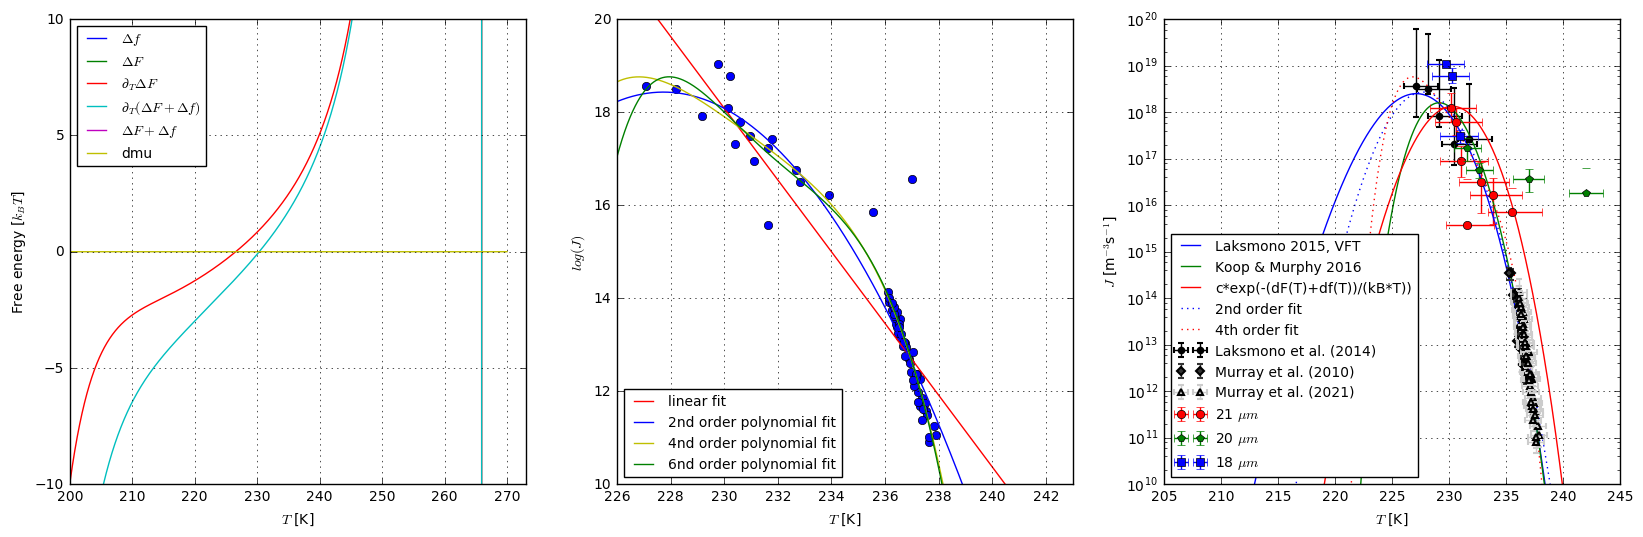

In [16]:
plt.clf()
f, axes = plt.subplots(nrows=1, ncols=3,  figsize=(20, 6))
#f.suptitle('')
err_linestyle = {"linewidth":1, "markeredgewidth":1.5, "elinewidth":1, "capsize":2}

# check energy barriers
#axes[0].plot(T, dF(T)/(kB*T), label="$\Delta F$")
#axes[0].semilogy(T, dF(T)/(kB*T), label="$\Delta F$")
#axes[0].semilogy(T, np.gradient(dF(T)/(kB*T), np.gradient(T)), label="$\partial_T \Delta F$")
#axes[0].semilogy(T, np.gradient((dF(T)+df(T))/(kB*T), np.gradient(T)), label="$\partial_T (\Delta F + \Delta f)$")
#axes[0].semilogy(T, (dF(T)+df(T))/(kB*T), label="$\Delta F + \Delta f$")
#axes[0].semilogy(T, -dmu(T), label="dmu")
# --- same in linear scale
axes[0].plot(T, df(T)/(kB*T), label="$\Delta f$")
axes[0].plot(T, dF(T)/(kB*T), label="$\Delta F$")
axes[0].plot(T, np.gradient(dF(T)/(kB*T), np.gradient(T)), label="$\partial_T \Delta F$")
axes[0].plot(T, np.gradient((dF(T)+df(T))/(kB*T), np.gradient(T)), label="$\partial_T (\Delta F + \Delta f)$")
axes[0].plot(T, (dF(T)+df(T))/(kB*T), label="$\Delta F + \Delta f$")
axes[0].plot(T, -dmu(T), label="dmu")
#
axes[0].set_xlim(200, 273)
axes[0].set_ylim(-1e+1, 1e+1)
axes[0].set_xlabel('$T$ [K]')
axes[0].set_ylabel('Free energy [$k_B T$]')
axes[0].grid(linestyle='dotted')
axes[0].legend(loc='upper left', prop={'size': 10})

# take logarithm of the data and plot + plot fit to log(data)
axes[1].plot(T_fit_data, log_J_fit_data, ls='none', marker='o')
axes[1].plot(T, func1(T, *popt1), ls="-", color="r", label="linear fit")
axes[1].plot(T, func2(T, *popt2), ls="-", color="b", label="2nd order polynomial fit")
axes[1].plot(T, func4(T, *popt4), ls="-", color="y", label="4nd order polynomial fit")
axes[1].plot(T, func6(T, *popt6), ls="-", color="g", label="6nd order polynomial fit")
#axes[1].plot(T, p(T), ls="-", color="g", label="4th order polynomial fit")
axes[1].set_xlim(226, 243)
axes[1].set_ylim(10, 20)
axes[1].set_xlabel('$T$ [K]')
axes[1].set_ylabel('$log(J)$')
axes[1].grid(linestyle='dotted')
axes[1].legend(loc='lower left', prop={'size': 10})

# parameterizations + fits
axes[2].semilogy(T, Jnuc_LM(T), label="Laksmono 2015, VFT")
axes[2].semilogy(T, Jnuc_KM(T), label="Koop & Murphy 2016")
axes[2].semilogy(T, 1.0e+51*np.exp(-(dF(T)+df(T))/(kB*T)), label="c*exp(-(dF(T)+df(T))/(kB*T))")
axes[2].semilogy(T, np.power(10, func2(T, *popt2)), ls="dotted", color="b", label="2nd order fit")
axes[2].semilogy(T, np.power(10, func4(T, *popt4)), ls="dotted", color="r", label="4th order fit")
axes[2].set_xlim(205, 245)
axes[2].set_ylim(1e+10, 1e+20)
axes[2].set_xlabel('$T$ [K]')
axes[2].set_ylabel('$J$ [m$^{-3}$s$^{-1}$]')
axes[2].grid(linestyle='dotted')
# exp data
axes[2].errorbar(T_laksmono, J_laksmono, xerr=[T_laksmono_low, T_laksmono_high], yerr=[J_laksmono_low, J_laksmono_high], fmt='ko', ms=4, label='Laksmono et al. (2014)', **err_linestyle)
axes[2].errorbar(T_Ben1, J_Ben1, yerr=[J_down_Ben1, J_up_Ben1], fmt='D', color='0.2', ms=4, label='Murray et al. (2010)', **err_linestyle)
axes[2].errorbar(T_Ben2, J_Ben2, yerr=[J_down_Ben2, J_up_Ben2], fmt='D', color='0.2', ms=4, **err_linestyle)
axes[2].errorbar(T_Murray_R1, J_Murray_R1, yerr=[J_R1_down, J_R1_up], xerr=[T_R1_err, T_R1_err], fmt='^', color='0.8', ms=4, label='Murray et al. (2021)', **err_linestyle)
axes[2].errorbar(T_Murray_R2, J_Murray_R2, yerr=[J_R2_down, J_R2_up], xerr=[T_R2_err, T_R2_err], fmt='^', color='0.8', ms=4, **err_linestyle)
axes[2].errorbar(T_Murray_R3, J_Murray_R3, yerr=[J_R3_down, J_R3_up], xerr=[T_R3_err, T_R3_err], fmt='^', color='0.8', ms=4, **err_linestyle)
axes[2].errorbar(T1_MC[np.where(J1_MC > 0)], J1_MC[np.where(J1_MC > 0)], xerr=[T1_MC_low[np.where(J1_MC > 0)], T1_MC_high[np.where(J1_MC > 0)]], yerr=[J1_MC_low[np.where(J1_MC > 0)], J1_MC_high[np.where(J1_MC > 0)]] , label='21 $\mu m$', fmt='ro')
axes[2].errorbar(T2_MC[np.where(J2_MC > 0)], J2_MC[np.where(J2_MC > 0)], xerr=[T2_MC_low[np.where(J2_MC > 0)], T2_MC_high[np.where(J2_MC > 0)]], yerr=[J2_MC_low[np.where(J2_MC > 0)], J2_MC_high[np.where(J2_MC > 0)]] , label='20 $\mu m$', fmt='gp')
axes[2].errorbar(T3_MC[np.where(J3_MC > 0)], J3_MC[np.where(J3_MC > 0)], xerr=[T3_MC_low[np.where(J3_MC > 0)], T3_MC_high[np.where(J3_MC > 0)]], yerr=[J3_MC_low[np.where(J3_MC > 0)], J3_MC_high[np.where(J3_MC > 0)]] , label='18 $\mu m$', fmt='bs')
axes[2].legend(loc='lower left', prop={'size': 10})


plt.savefig('nucrate_fits.eps', format='eps')
plt.show()


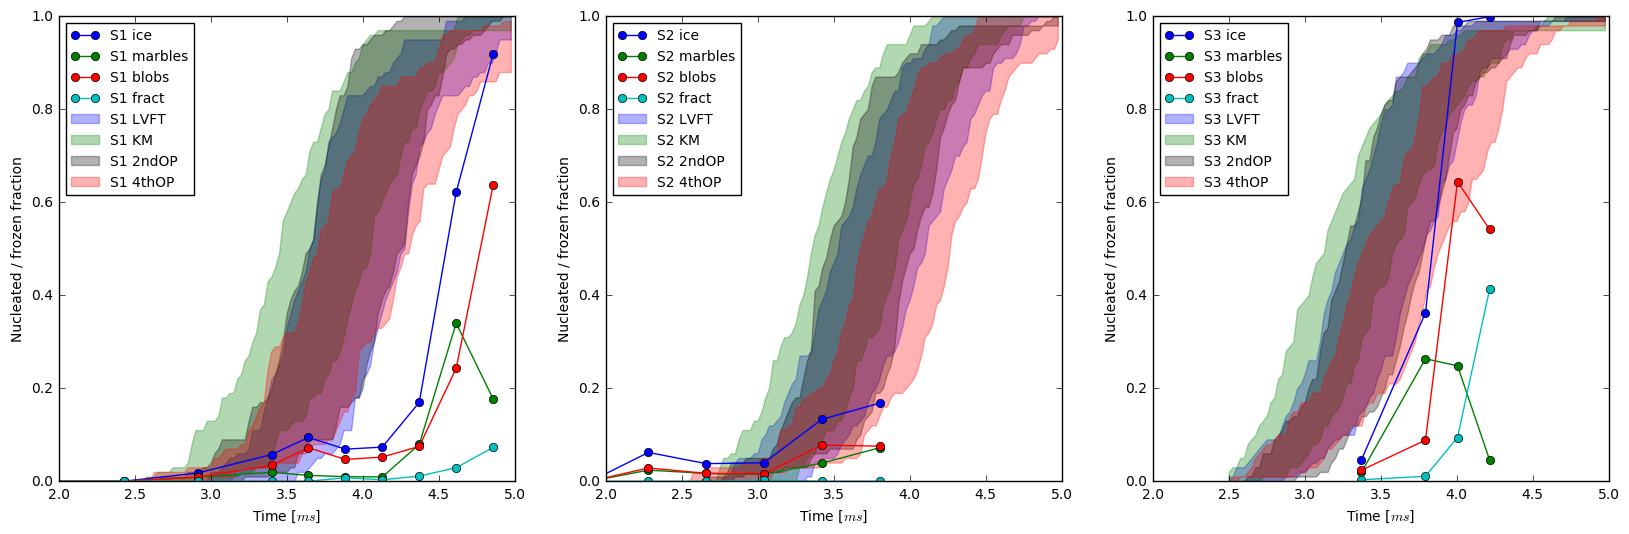

In [93]:
from scipy import stats
"""
Read files with data on nucleation/freezing time of stochastic nucleation simulations.
"""
# S1: 21.4 um; S2: 20.2 um; S3: 18.1 um
S1_KM_data = np.loadtxt('/Users/danielschlesinger/Desktop/DropletTrainExp/evapcool_20200104/stoch_nuc/S1_KM.dat')
S1_LVFT_data = np.loadtxt('/Users/danielschlesinger/Desktop/DropletTrainExp/evapcool_20200104/stoch_nuc/S1_L-VFT.dat')
S1_2ndOP_data = np.loadtxt('/Users/danielschlesinger/Desktop/DropletTrainExp/evapcool_20200104/stoch_nuc/S1_2ndOP.dat')
S1_4thOP_data = np.loadtxt('/Users/danielschlesinger/Desktop/DropletTrainExp/evapcool_20200104/stoch_nuc/S1_4thOP.dat')
#
S2_KM_data = np.loadtxt('/Users/danielschlesinger/Desktop/DropletTrainExp/evapcool_20200104/stoch_nuc/S2_KM.dat')
S2_LVFT_data = np.loadtxt('/Users/danielschlesinger/Desktop/DropletTrainExp/evapcool_20200104/stoch_nuc/S2_L-VFT.dat')
S2_2ndOP_data = np.loadtxt('/Users/danielschlesinger/Desktop/DropletTrainExp/evapcool_20200104/stoch_nuc/S2_2ndOP.dat')
S2_4thOP_data = np.loadtxt('/Users/danielschlesinger/Desktop/DropletTrainExp/evapcool_20200104/stoch_nuc/S2_4thOP.dat')
#
S3_KM_data = np.loadtxt('/Users/danielschlesinger/Desktop/DropletTrainExp/evapcool_20200104/stoch_nuc/S3_KM.dat')
S3_LVFT_data = np.loadtxt('/Users/danielschlesinger/Desktop/DropletTrainExp/evapcool_20200104/stoch_nuc/S3_L-VFT.dat')
S3_2ndOP_data = np.loadtxt('/Users/danielschlesinger/Desktop/DropletTrainExp/evapcool_20200104/stoch_nuc/S3_2ndOP.dat')
S3_4thOP_data = np.loadtxt('/Users/danielschlesinger/Desktop/DropletTrainExp/evapcool_20200104/stoch_nuc/S3_4thOP.dat')
#
S1_LVFT_nuc, S1_LVFT_frz   = S1_LVFT_data[:,1], S1_LVFT_data[:,2]
S1_KM_nuc, S1_KM_frz       = S1_KM_data[:,1], S1_KM_data[:,2]
S1_2ndOP_nuc, S1_2ndOP_frz = S1_2ndOP_data[:,1], S1_2ndOP_data[:,2]
S1_4thOP_nuc, S1_4thOP_frz = S1_4thOP_data[:,1], S1_4thOP_data[:,2]
#
S2_LVFT_nuc, S2_LVFT_frz   = S2_LVFT_data[:,1], S2_LVFT_data[:,2]
S2_KM_nuc, S2_KM_frz       = S2_KM_data[:,1], S2_KM_data[:,2]
S2_2ndOP_nuc, S2_2ndOP_frz = S2_2ndOP_data[:,1], S2_2ndOP_data[:,2]
S2_4thOP_nuc, S2_4thOP_frz = S2_4thOP_data[:,1], S2_4thOP_data[:,2]
#
S3_LVFT_nuc, S3_LVFT_frz   = S3_LVFT_data[:,1], S3_LVFT_data[:,2]
S3_KM_nuc, S3_KM_frz       = S3_KM_data[:,1], S3_KM_data[:,2]
S3_2ndOP_nuc, S3_2ndOP_frz = S3_2ndOP_data[:,1], S3_2ndOP_data[:,2]
S3_4thOP_nuc, S3_4thOP_frz = S3_4thOP_data[:,1], S3_4thOP_data[:,2]

"""
From stochastic nucleation simulations, calculate cumulative histograms of 
nucleated / frozen fraction vs time and plot those. 
"""
nbins = 100
N = len(S3_LVFT_nuc)         # should really be number of independent stochastic simulations runs
llim  = 0.0025
ulim  = 0.0050
t = np.array([llim + (ulim-llim)*i/nbins for i in range(0, nbins)])*1000.0
#
S1_LVFT_nuc_hist = stats.cumfreq(S1_LVFT_nuc, numbins=nbins, defaultreallimits=(llim, ulim)) 
S1_LVFT_frz_hist = stats.cumfreq(S1_LVFT_frz, numbins=nbins, defaultreallimits=(llim, ulim))
S1_KM_nuc_hist = stats.cumfreq(S1_KM_nuc, numbins=nbins, defaultreallimits=(llim, ulim))
S1_KM_frz_hist = stats.cumfreq(S1_KM_frz, numbins=nbins, defaultreallimits=(llim, ulim))
S1_2ndOP_nuc_hist = stats.cumfreq(S1_2ndOP_nuc, numbins=nbins, defaultreallimits=(llim, ulim))
S1_2ndOP_frz_hist = stats.cumfreq(S1_2ndOP_frz, numbins=nbins, defaultreallimits=(llim, ulim))
S1_4thOP_nuc_hist = stats.cumfreq(S1_4thOP_nuc, numbins=nbins, defaultreallimits=(llim, ulim))
S1_4thOP_frz_hist = stats.cumfreq(S1_4thOP_frz, numbins=nbins, defaultreallimits=(llim, ulim))
#
S2_LVFT_nuc_hist = stats.cumfreq(S2_LVFT_nuc, numbins=nbins, defaultreallimits=(llim, ulim))
S2_LVFT_frz_hist = stats.cumfreq(S2_LVFT_frz, numbins=nbins, defaultreallimits=(llim, ulim))
S2_KM_nuc_hist = stats.cumfreq(S2_KM_nuc, numbins=nbins, defaultreallimits=(llim, ulim))
S2_KM_frz_hist = stats.cumfreq(S2_KM_frz, numbins=nbins, defaultreallimits=(llim, ulim))
S2_2ndOP_nuc_hist = stats.cumfreq(S2_2ndOP_nuc, numbins=nbins, defaultreallimits=(llim, ulim))
S2_2ndOP_frz_hist = stats.cumfreq(S2_2ndOP_frz, numbins=nbins, defaultreallimits=(llim, ulim))
S2_4thOP_nuc_hist = stats.cumfreq(S2_4thOP_nuc, numbins=nbins, defaultreallimits=(llim, ulim))
S2_4thOP_frz_hist = stats.cumfreq(S2_4thOP_frz, numbins=nbins, defaultreallimits=(llim, ulim))
#
S3_LVFT_nuc_hist = stats.cumfreq(S3_LVFT_nuc, numbins=nbins, defaultreallimits=(llim, ulim))
S3_LVFT_frz_hist = stats.cumfreq(S3_LVFT_frz, numbins=nbins, defaultreallimits=(llim, ulim))
S3_KM_nuc_hist = stats.cumfreq(S3_KM_nuc, numbins=nbins, defaultreallimits=(llim, ulim))
S3_KM_frz_hist = stats.cumfreq(S3_KM_frz, numbins=nbins, defaultreallimits=(llim, ulim))
S3_2ndOP_nuc_hist = stats.cumfreq(S3_2ndOP_nuc, numbins=nbins, defaultreallimits=(llim, ulim))
S3_2ndOP_frz_hist = stats.cumfreq(S3_2ndOP_frz, numbins=nbins, defaultreallimits=(llim, ulim))
S3_4thOP_nuc_hist = stats.cumfreq(S3_4thOP_nuc, numbins=nbins, defaultreallimits=(llim, ulim))
S3_4thOP_frz_hist = stats.cumfreq(S3_4thOP_frz, numbins=nbins, defaultreallimits=(llim, ulim))

"""
Data from lab experiments (Mar-Dec 2020)
"""
# --- Mar 2020
time1 = np.array([1.068999028, 1.554907677, 1.943634597, 2.429543246, 2.915451895, 3.401360544,
                  3.644314869, 3.887269193, 4.130223518, 4.373177843, 4.616132167, 4.859086492])  # ms
# counts
ntot1 = np.array([357, 183, 105, 158, 113, 471, 319, 406, 327, 454, 206, 220])
nmarbles1 = np.array([0, 0, 0, 0, 1, 9, 4, 4, 3, 36, 70, 39])
nblobs1 = np.array([0, 0, 0, 0, 1, 16, 23, 19, 17, 34, 50, 140])
nfract1 = np.array([0, 0, 0, 0, 0, 0, 0, 3, 1, 5, 6, 16])
ndist1 = np.array([0, 0, 0, 0, 0, 2, 3, 2, 3, 2, 2, 7])
# fractions
fice1 = (nmarbles1 + nblobs1 + nfract1 + ndist1)/ntot1.astype(np.float)
fmarbles1 = nmarbles1/ntot1.astype(np.float)
fblobs1 = nblobs1/ntot1.astype(np.float)
ffract1 = nfract1/ntot1.astype(np.float)
fdist1 = ndist1/ntot1.astype(np.float)
# --- Nov 3 2020
time2 = np.array([1.140684411, 1.520912548, 1.901140684, 2.281368821,
                  2.661596958, 3.041825095, 3.422053232, 3.802281369])  # ms
# counts
ntot2 = np.array([48, 39, 34, 210, 715, 881, 797, 292])
nmarbles2 = np.array([0, 1, 0, 5, 12, 13, 31, 21])
nblobs2 = np.array([0, 0, 0, 6, 12, 14, 62, 22])
nfract2 = np.array([0, 0, 0, 0, 0, 2, 0, 0])
ndist2 = np.array([0, 0, 0, 2, 3, 6, 13, 6])
# fractions
fice2 = (nmarbles2 + nblobs2 + nfract2 + ndist2)/ntot2.astype(np.float)
fmarbles2 = nmarbles2/ntot2.astype(np.float)
fblobs2 = nblobs2/ntot2.astype(np.float)
ffract2 = nfract2/ntot2.astype(np.float)
fdist2 = ndist2/ntot2.astype(np.float)
# --- Dec 2020
time3 = np.array([3.373060174, 3.794692695, 4.005508956, 4.216325217])
# counts
ntot3 = np.array([633, 566, 298, 325])
nmarbles3 = np.array([12, 149, 74, 15])
nblobs3 = np.array([15, 50, 192, 176])
nfractdist3 = np.array([2, 6, 28, 134])
# nwater3 = np.array([604, 361, 4, 0]) # ntot3 - nblobs3 - nmarbles3 - nfractdist3
# fractions
fice3 = (nmarbles3 + nblobs3 + nfractdist3)/ntot3.astype(np.float)
fmarbles3 = nmarbles3/ntot3.astype(np.float)
fblobs3 = nblobs3/ntot3.astype(np.float)
ffractdist3 = nfractdist3/ntot3.astype(np.float)
# numerical correction to 100% ice
fice3[np.where(fice3 >= 1)] = 0.999
#fice3[np.where(fice3 >= 1)] = 0.999999

# --- Nov 3 2020
# total
time = np.hstack([time1, time2, time3])
setindex = np.array([len(time1), len(time1)+len(time2),
                     len(time1)+len(time2)+len(time3)])
fice = np.hstack([fice1, fice2, fice3])
fmarbles = np.hstack([fmarbles1, fmarbles2, fmarbles3])
fblobs = np.hstack([fblobs1, fblobs2, fblobs3])
ffractdist = np.hstack([ffract1+fdist1, ffract2+fdist2, ffractdist3])


"""
Plots
"""
plt.clf()
f, axes = plt.subplots(nrows=1, ncols=3,  figsize=(20, 6))
#axes[0].plot(t, S1_LVFT_nuc_hist.cumcount, label='S1 KM nuc', color='b')
#axes[0].plot(t, S1_LVFT_frz_hist.cumcount, label='S1 KM frz', color='b')
#axes[0].set_ylim(0, 100)

alph = 0.3
axes[0].fill_between(t, S1_LVFT_nuc_hist.cumcount/N, S1_LVFT_frz_hist.cumcount/N, alpha=alph, label='S1 LVFT', color='b')
axes[0].fill_between(t, S1_KM_nuc_hist.cumcount/N, S1_KM_frz_hist.cumcount/N, alpha=alph, label='S1 KM', color='g')
axes[0].fill_between(t, S1_2ndOP_nuc_hist.cumcount/N, S1_2ndOP_frz_hist.cumcount/N, alpha=alph, label='S1 2ndOP', color='k')
axes[0].fill_between(t, S1_4thOP_nuc_hist.cumcount/N, S1_4thOP_frz_hist.cumcount/N, alpha=alph, label='S1 4thOP', color='r')
axes[0].plot(time1, fice1, label='S1 ice', marker='o')
axes[0].plot(time1, fmarbles1, label='S1 marbles', marker='o')
axes[0].plot(time1, fblobs1, label='S1 blobs', marker='o')
axes[0].plot(time1, ffract1, label='S1 fract', marker='o')
axes[0].set_xlim(2.0, 5.0)
axes[0].legend(loc='upper left', prop={'size': 10})
axes[0].set_xlabel("Time [$ms$]")
axes[0].set_ylabel("Nucleated / frozen fraction")
#
axes[1].fill_between(t, S2_LVFT_nuc_hist.cumcount/N, S2_LVFT_frz_hist.cumcount/N, alpha=alph, label='S2 LVFT', color='b')
axes[1].fill_between(t, S2_KM_nuc_hist.cumcount/N, S2_KM_frz_hist.cumcount/N, alpha=alph, label='S2 KM', color='g')
axes[1].fill_between(t, S2_2ndOP_nuc_hist.cumcount/N, S2_2ndOP_frz_hist.cumcount/N, alpha=alph, label='S2 2ndOP', color='k')
axes[1].fill_between(t, S2_4thOP_nuc_hist.cumcount/N, S2_4thOP_frz_hist.cumcount/N, alpha=alph, label='S2 4thOP', color='r')
axes[1].plot(time2, fice2, label='S2 ice', marker='o')
axes[1].plot(time2, fmarbles2, label='S2 marbles', marker='o')
axes[1].plot(time2, fblobs2, label='S2 blobs', marker='o')
axes[1].plot(time2, ffract2, label='S2 fract', marker='o')
axes[1].legend(loc='upper left', prop={'size': 10})
axes[1].set_xlim(2.0, 5.0)
axes[1].set_xlabel("Time [$ms$]")
axes[1].set_ylabel("Nucleated / frozen fraction")
#
axes[2].fill_between(t, S3_LVFT_nuc_hist.cumcount/N, S3_LVFT_frz_hist.cumcount/N, alpha=alph, label='S3 LVFT', color='b')
axes[2].fill_between(t, S3_KM_nuc_hist.cumcount/N, S3_KM_frz_hist.cumcount/N, alpha=alph, label='S3 KM', color='g')
axes[2].fill_between(t, S3_2ndOP_nuc_hist.cumcount/N, S3_2ndOP_frz_hist.cumcount/N, alpha=alph, label='S3 2ndOP', color='k')
axes[2].fill_between(t, S3_4thOP_nuc_hist.cumcount/N, S3_4thOP_frz_hist.cumcount/N, alpha=alph, label='S3 4thOP', color='r')
axes[2].plot(time3, fice3, label='S3 ice', marker='o')
axes[2].plot(time3, fmarbles3, label='S3 marbles', marker='o')
axes[2].plot(time3, fblobs3, label='S3 blobs', marker='o')
axes[2].plot(time3, ffractdist3, label='S3 fract', marker='o')
axes[2].legend(loc='upper left', prop={'size': 10})
axes[2].set_xlim(2.0, 5.0)
axes[2].set_xlabel("Time [$ms$]")
axes[2].set_ylabel("Nucleated / frozen fraction")
#
plt.savefig('nuc-frz_cumhist.png', format='png', dpi=600)
plt.show()

In [ ]:
# WolframAlpha input to find root of \Delta\mu -> Tm \approx 266.11 (melting temp shift due to conversion Ih->Ic!)
Solve[-6007.2*x*(1/x-1/273.16)+155+11.847719e-3*exp(-5412.2*(1/x-1/273.16))*(1.0-exp(-722.5*(1/x-1/273.16))*exp(18.6422150316/x)) + 0.03267 = 0, x]
Diff[-6007.2*x*(1/x-1/273.16)+155+11.847719e-3*exp(-5412.2*(1/x-1/273.16))*(1.0-exp(-722.5*(1/x-1/273.16))*exp(18.6422150316/x)) + 0.03267, x]
Solve[(-9.09495×10^-13 x - 4.10778×10^11 e^(-6116.06/x) + 2.58115×10^10 e^(-5412.2/x))/x^2 + 21.9915, x=266.11]
#results in d\mu/dT |_Tm \approx 21.9915 J/mol/K (in WolframAlpha inputs \mu in units of J/mol not J/molecule!)